### Part 1: Import necessary library for the implementation

In [23]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential as Seq, Linear, ReLU, BatchNorm1d as BN
from torch.utils.data import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool
import matplotlib.pyplot as plt 
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score

In [39]:
def create_graph(df):
    G = nx.DiGraph()
    node_mapping = {}

    #This keeps the track of unique node IDs
    node_counter = 0

    # Grouping by timestamp and iterating over each group
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d/%m/%Y %I:%M:%S %p")
    df["timestamp_minute"] = df["Timestamp"].dt.floor("min")
    df = df.sort_values(by=["Timestamp"])
    
    for timestamp_minute, group in df.groupby("timestamp_minute"):
        # L is temporary list that would hold node IDs before they are being appeneded to N
        N = []
        L = []

        for idx, row in group.iterrows():
            src_ip = row["Src IP"]
            dst_ip = row["Dst IP"]
            flow_id = row["Flow ID"]

            fwd_node = f"{src_ip}_{flow_id}"
            bwd_node = f"{flow_id}_{dst_ip}"

            # Checks if fwd_node and bwd_node are not in node mapping. If its not in the 
            # node mapping already, it assigned a unique numerical ID to each and increment 
            if fwd_node not in node_mapping:
                node_mapping[fwd_node] = node_counter
                node_counter += 1
            if bwd_node not in node_mapping:
                node_mapping[bwd_node] = node_counter
                node_counter += 1

            fwd_node_id = node_mapping[fwd_node]
            bwd_node_id = node_mapping[bwd_node]

            # check if fwd_node_id is in L, and append things in L to N for the next group. Continue
            if fwd_node_id not in L:
                if L:
                    N.append(L)
                    L = []
                L.append(fwd_node_id)
            if bwd_node_id not in L:
                if L:
                    N.append(L)
                    L = []
                L.append(bwd_node_id)

            # Checks if N has more than one group. 
            if len(N) > 1:
                # If it is true, it iterates over nodes in L and connects them to node in previous group in the graph 
                for node in L:
                    for prev_node in N[-2]:
                        G.add_edge(prev_node, node, timestamp=timestamp_minute)

            # Determine label (benign or malicious)
            # 1 if it is malicious and 0 if is benign
            fwd_label = row["Label"].lower()
            label = 1 if fwd_label in ["Non-Tor", "VPN"] else 0

            G.add_node(fwd_node_id, type='forward', features=torch.tensor([
                row["Total Fwd Packet"],
                row["Fwd Packets/s"],
                row["Fwd IAT Std"],
                row["Total Length of Fwd Packet"],
                row["Fwd Packet Length Std"],
                row["Fwd Segment Size Avg"],
                row["FWD Init Win Bytes"],
                row["Fwd Packet Length Mean"],
                row["Fwd IAT Max"],
                row["Average Packet Size"],
                row["Subflow Fwd Bytes"]
            ], dtype=torch.float), label=label)

            G.add_node(bwd_node_id, type='backward', features=torch.tensor([
                row["Total Fwd Packet"],  # Corrected from Fwd to Bwd
                -row["Bwd Packets/s"],    # Negative for backward
                row["Bwd IAT Std"],
                row["Total Length of Bwd Packet"],
                row["Bwd Packet Length Std"],
                row["Bwd Segment Size Avg"],
                row["Bwd Init Win Bytes"],
                row["Bwd Packet Length Mean"],
                row["Bwd IAT Max"],
                row["Average Packet Size"],
                row["Subflow Bwd Bytes"]
            ], dtype=torch.float), label=label)

            G.add_edge(fwd_node_id, bwd_node_id, timestamp=timestamp_minute,
                       packet_count=row["Total Fwd Packet"], total_bytes=row["Total Length of Fwd Packet"])
        # Checks if L is non-empty at the end of the group iteration. If true, appends L to N
        if L:
            N.append(L)

    # Adding label attribute to the graph
    nx.set_node_attributes(G, {node: G.nodes[node]['label'] for node in G.nodes()}, name='label')

    return G


In [44]:
csv_file = "C:/Users/seoji/Downloads/GraphSAGE-master/DGNN/graph_creation/data/Darknet.CSV"
file = pd.read_csv(csv_file)
g = create_graph(file)

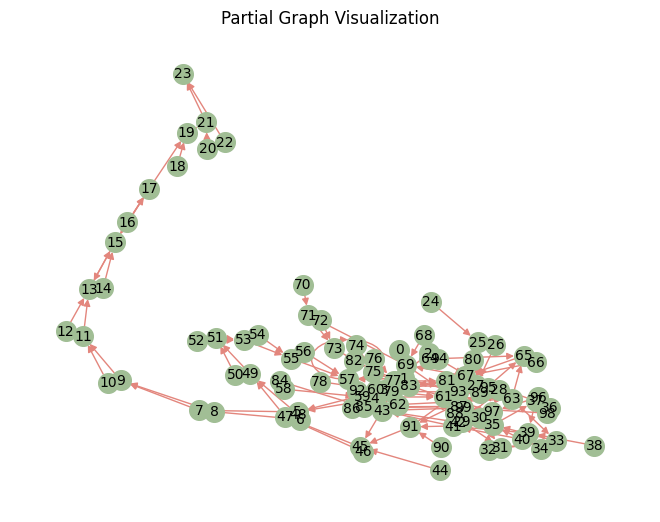

In [21]:
nodes = list(file.nodes())[:100]
edges = list(file.edges())[:200]

small_graph = file.subgraph(nodes).copy()

pos = nx.spring_layout(small_graph)
nx.draw(small_graph, pos, with_labels = True, node_color ='#A1BE95', edge_color='#E3867D', node_size=200, font_size=10)
plt.title('Partial Graph Visualization')
plt.show()

### Start building GIN Model using Library

In [24]:
class GINModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if batch is None:
            x = global_mean_pool(x, None)
        else:
            x = global_mean_pool(x, batch)
        
        x = F.log_softmax(self.fc(x), dim=1)
        return x


It needs to be in PyTorch format... But it is currently on testing..

In [42]:
import torch
from torch_geometric.data import Data

def graph_to_pyg_data(G):
    data = Data()

    node_features = {}
    for node in G.nodes():
        if 'features' in G.nodes[node]:
            node_features[node] = G.nodes[node]['features']

    first_node_features_shape = None
    for node in node_features:
        if first_node_features_shape is None:
            first_node_features_shape = node_features[node].shape
    x = torch.stack([node_features[node] for node in sorted(G.nodes())])

    data.x = x

    edge_index = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])  
        edge_index.append([edge[1], edge[0]])  

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    if edge_index.size(0) != 2:
        edge_index = edge_index.view(2, -1)

    data.edge_index = edge_index

    if 'label' in G.nodes[node]:
        labels = [G.nodes[node]['label'] for node in sorted(G.nodes())]
        data.y = torch.tensor(labels, dtype=torch.long)

    print(data.y) # contains whether it is malicious or not
    print(data.x)

    return data


In [45]:
file = graph_to_pyg_data(g)

tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([[ 2.0000e+00,  9.4641e-01,  0.0000e+00,  ...,  2.1132e+06,
          2.8650e+02,  1.9100e+02],
        [ 2.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          2.8650e+02,  0.0000e+00],
        [ 1.0000e+00,  2.2371e+03,  0.0000e+00,  ...,  0.0000e+00,
          1.0450e+02,  1.7000e+01],
        ...,
        [ 8.0000e+00, -7.0141e+00,  1.8878e+05,  ...,  4.4958e+05,
          1.7529e+01,  8.0000e+00],
        [ 8.0000e+00,  5.1475e+00,  2.7383e+05,  ...,  7.1796e+05,
          1.8941e+01,  7.0000e+00],
        [ 8.0000e+00, -5.7910e+00,  2.5995e+05,  ...,  7.1763e+05,
          1.8941e+01,  1.1000e+01]])
